In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm 

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap
from ConfigDataset import ConfigDataset
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()
sys.path.insert(2,'../diffusion/')
from classifier_free_guidance_greg import Unet, GaussianDiffusion

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /state/partition1/slurm_tmp/24967521.0.0/tmp1iahodko
INFO:torch.distributed.nn.jit.instantiator:Writing /state/partition1/slurm_tmp/24967521.0.0/tmp1iahodko/_remote_module_non_scriptable.py
2024-02-06 13:21:51.817763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pickle

In [5]:
chroms = ['1','X']
region_idx = None #None if no restriction
nbeads = 64
resolution = 20_000
embeddings_nbeads = 65 
#sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_final_embeddings/'
#sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_no_embed_reduction/'
sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_experimental_hic//'
mean_dist_fp = '../../data/mean_dists.pt'
'''
cond_scales = 2.#5.#.4 #[k/10 for k in range(10)]#[0.5,1.,2.,3.,4.,5.]
rescaled_phis = 10#5.#.4 #[k/10 for k in range(10)]
milestones = 120#240 
'''
'''
cond_scales = .9
rescaled_phis = .9
milestones = 120
'''
cond_scales = None#.4
rescaled_phis = None#.4
milestones = None#240
region_idxs = None 
r_c = 1.6
sigma = 6

In [6]:
config_ds = ConfigDataset(
    filepath='../../data/processed_data.hdf5',
    segment_length=nbeads,
    allow_overlap=True,
    chroms = chroms,
    replicates=[1]
)

In [7]:
exp_hic = HiCDataset()

In [8]:
#emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings_{embeddings_nbeads}/chrom_{chrom}.tar.gz'
embeddings_dict = {}
for chrom in chroms: 
    embeddings_dict[chrom] = pd.read_pickle(emb_fp(chrom))

In [9]:
def get_tan_coords(region_idx=region_idx,embeddings=embeddings_dict[chroms[0]]):
    _,chrom,start_idx = embeddings.index[region_idx]
    _,coords = config_ds.fetch_specific_coords(chrom,start_idx)
    return coords

In [10]:
def remove_diagonal(x):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,1)
    x2 = torch.empty(*x.shape[:-2],s-1,s-1,dtype=x.dtype,device=x.device)
    x2[...,i,j-1] = x[...,i,j]
    x2[...,j-1,i] = x[...,j,i]
    return x2

def add_diagonal(x,diag_value=0):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,0)
    x2 = torch.empty(*x.shape[:-2],s+1,s+1,dtype=x.dtype,device=x.device)
    x2[...,i,j+1] = x[...,i,j]
    x2[...,j+1,i] = x[...,j,i] 
    i = torch.arange(s+1)
    x2[...,i,i] = diag_value
    return x2
    
def get_tan_sample(
    region_idx,
    chrom,
    embeddings={chrom:embeddings_dict[chrom] for chrom in chroms}
):
    coords = get_tan_coords(region_idx,embeddings[chrom])
    dists = torch.cdist(coords,coords)
    return Sample(data=remove_diagonal(dists))

In [11]:
def get_exp_map(
    region_idx,
    chrom,
    exp_hic=exp_hic,
    emb_idx={chrom:embeddings_dict[chrom].index for chrom in chroms},
    interp_nans=True,
    region_length=nbeads*20_000
):

    # Get the region information from the embedding index used during sample generation
    region_length1, chrom, start = emb_idx[chrom][region_idx]
    region_length = region_length1 if region_length is None else region_length
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [12]:
#_,chrom_,si = embeddings_dict[chroms[0]].index[region_idx]
#assert chrom == chrom_ 
def compare_to_exp(gen_map,region_index=region_idx):
    exp_map = get_exp_map(region_index)
    pcc = gen_map.pcc(exp_map)
    fig,ax,im,cbar = exp_map.plot_with(gen_map)
    ax.set_title(f'Chrom {chrom}, {si}-{si+nbeads*20_000}\nPCC: {pcc}')
    return fig, ax, im, cbar

In [13]:
def load_sample(
    filepath = None,
    directory=sample_directory, #'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/diffusion_v1/sampling_small/',
    region_idx=0,
    cond_scale=1.,
    rescaled_phi=.7,
    milestone=69,
    chrom=1
):

    if filepath is None: 
        if directory != '' and directory[-1] != '/':
            directory+= '/'
        
        fps = [ # placed in order of preference, per the next loop 
            f'{directory}sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pt',
            f'{directory}sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pkl',
            f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pt',
            f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
        ]
        for fp in fps: 
            if os.path.exists(fp):
                break
    else: 
        fp = filepath 

    if fp.split('.')[-1] == 'pkl':
        data = pd.read_pickle(fp).unflatten()
    else:
        data = torch.load(fp)
        if data.shape[-3] == 2:
            data = origami_transform.inverse(data)
            data = remove_diagonal(data)
    if len(data.shape) == 2: 
        data = data.unsqueeze(0)
    #if len(data.shape) == 3:
    #    data = data.unsqueeze(1)

    return Sample(data=data)
    #return pd.read_pickle(fp)
    #return Sample(data=pd.read_pickle(fp).batch)
    


In [14]:
def tanh_map_quartic(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten().to('cuda' if torch.cuda.is_available() else None)

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten().to('cuda' if torch.cuda.is_available() else None)

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**3
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

def thresh_map(sample,r_c):
    '''
    Avoid using distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten().to('cuda' if torch.cuda.is_available() else None)

    below_thresh = (r < r_c).float()
    below_thresh[r.isnan()] = torch.nan
    
    return HiCMap(torch.nanmean(below_thresh,dim=0).squeeze(),includes_self_interaction=False)
    

In [15]:
def nanstd(x,dim=None):
    return ( torch.nanmean(x**2,dim=dim) - torch.nanmean(x,dim=dim)**2 ).sqrt()
    
def get_std(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return nanstd(x,dim=0)

def get_mean(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return torch.nanmean(x,dim=0)

def plot_stats_2d(mean_gen,fig=None,ax=None,distances=True):

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
        
    im = ax.matshow(mean_gen.prob_map.cpu().numpy(),cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(
        im,
        label = 'Distance' if distances else 'Distance Standard Deviation',
        ax=ax
    )
    
    return fig, ax, im, cbar

def plot_stats_1d(mean_gen,fig=None,ax=None,distances=True):

    x = mean_gen.prob_map.cpu().numpy()
    i,j = torch.triu_indices(x.shape[-1],x.shape[-1],1)

    x,y = x[i,j], x[j,i]

    v = [max(x.min(),y.min()),min(x.max(),y.max())]

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
    ax.plot(x,y,'.')
    ax.plot(v,v)
    if distances:
        ax.set_xlabel('Mean Distances: Tan Dataset')
        ax.set_ylabel('Mean Distances: Generated Data')
    else:
        ax.set_xlabel('Distance Standard Deviation: Tan Dataset')
        ax.set_ylabel('Distance Standard Deviation: Generated Data')
    
    return fig,ax

def plot_stats(sample,sample_tan):

    std_tan = HiCMap(sample_tan.unflatten().std(0).squeeze())
    mean_tan = HiCMap(sample_tan.unflatten().mean(0).squeeze())

    std_gen = HiCMap(get_std(sample))
    pcc_std = std_gen.pcc(std_tan)
    std_gen.replace_lower_triangle(std_tan)
    std_gen.T_()

    mean_gen = HiCMap(get_mean(sample))
    pcc_mean = mean_gen.pcc(mean_tan)
    mean_gen.replace_lower_triangle(mean_tan)
    mean_gen.T_()

    ########
    # plots
    fig = plt.figure(figsize=(10,7.5))
    ax1 = fig.add_subplot(221)
    plot_stats_2d(mean_gen,fig=fig,ax=ax1,distances=True)
    ax1.set_title(f'PCC: {pcc_mean}')
    ax2 = fig.add_subplot(222)
    plot_stats_1d(mean_gen,fig=fig,ax=ax2,distances=True)
    ax3 = fig.add_subplot(223)
    plot_stats_2d(std_gen,fig=fig,ax=ax3,distances=False)
    ax3.set_title(f'PCC: {pcc_std}')
    ax4 = fig.add_subplot(224)
    plot_stats_1d(std_gen,fig=fig,ax=ax4,distances=False)

    return fig, ax1, ax2, ax3, ax4

In [16]:
def to_list(object):
    return object if type(object) == list else [object]

def parse_filename(filename):
    filename = filename.split('/')[-1]  # remove directory path
    components = filename.split('_')
    region_idx = int(components[1])
    cond_scale = float(components[2]) if '.' in components[2] else int(components[2])
    rescaled_phi = float(components[3]) if '.' in components[3] else int(components[3])
    milestone = int(components[4])
    chrom = components[5].split('.')[0]

    return region_idx, cond_scale, rescaled_phi, milestone, chrom

def is_valid(
    filename,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom
):

    try:
        ri, cs, rp, ms, ch = parse_filename(filename) 
    except:
        return False, (None, None, None, None, None)
    
    for desired,actual in [(region_idx,ri),(cond_scale,cs),
                         (rescaled_phi,rp),(milestone,ms),(chrom,ch)]:
        if desired is not None and actual not in to_list(desired):
            return False, (ri, cs, rp, ms, ch)
    
    return True, (ri, cs, rp, ms, ch)
    
def get_all_sample_types(
    sample_directory=sample_directory,
    *,
    region_idx=None,
    cond_scale=None,
    rescaled_phi=None,
    milestone=None,
    chrom = None
):
    samples = os.listdir(sample_directory)

    to_process = pd.DataFrame({
        'region_idx':[],
        'cond_scale':[],
        'rescaled_phi':[],
        'milestone':[],
        'chrom':[],
    })
    
    for f in samples:
        valid, properties = is_valid(f,region_idx,cond_scale,rescaled_phi,milestone,chrom) 
        if valid: 
            to_process.loc[len(to_process)] = properties

    to_process.sort_values(
        ['milestone','chrom','region_idx','cond_scale','rescaled_phi'], # sorts in this order
        inplace=True,
        ignore_index=True,
    )

    return [*to_process.itertuples(index=False,name=None)]

    
    

Get the set of valid files

In [38]:
def plot_results(
    sample_directory=sample_directory,
    cond_scales=cond_scales,
    rescaled_phis=rescaled_phis,
    milestones=milestones,
    chroms=chroms,
    region_idxs=region_idxs,
    r_c=r_c,
    sigma=sigma,
    use_thresholding=False,
    quartic=False
):
    sample_details = get_all_sample_types(sample_directory,cond_scale=cond_scales,rescaled_phi=rescaled_phis,milestone=milestones,chrom=chroms,region_idx=region_idxs)
    print(f'{len(sample_details)} samples to process',flush=True)

    last_ri = None
    last_chrom = None
    #for region_idx, cond_scale, rescaled_phi, milestone, chrom in sample_details: 
    for region_idx, cond_scale, rescaled_phi, milestone, chrom in tqdm(sample_details,total=len(sample_details),desc='Progress: '): 
        
        # Load the sample 
        sample = load_sample(
            region_idx=region_idx,
            cond_scale=cond_scale,
            rescaled_phi=rescaled_phi,
            milestone=milestone,
            chrom = chrom
        )
    
        start_idx = embeddings_dict[chrom].index[region_idx][-1]
        stop_idx = start_idx + nbeads * resolution
        # Get the contact probability map 
        if use_thresholding:
            gen_probs_uncorrected = thresh_map(sample,r_c)
        else:
            if quartic:
                gen_probs_uncorrected = tanh_map_quartic(sample,r_c,sigma)
            else:
                gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
        #gen_probs_uncorrected = thresh_map(sample,r_c)
    
        #####
        # Plot it against experimental probabilities
        if region_idx != last_ri or chrom != last_chrom:
            exp_probs = get_exp_map(region_idx,chrom)
        _,ax,_,_ = exp_probs.plot_with(gen_probs_uncorrected)
        ax.set_title(
            f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
            f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
            f'PCC: {exp_probs.pcc(gen_probs_uncorrected)}'
        )
    
        #####
        # Plot it against Longzhi Tan-derived data
    
        # Load the relevant tan data 
        if region_idx != last_ri or chrom != last_chrom:
            sample_tan = get_tan_sample(region_idx,chrom)
            tan_map = tanh_map(sample_tan,r_c,sigma)
    
        # Probability map comparison
        _,ax,_,_ = tan_map.plot_with(gen_probs_uncorrected)
        ax.set_title(
            f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
            f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
            f'PCC: {tan_map.pcc(gen_probs_uncorrected)}'
        )
    
        # Compare the generated distance statistics to the Longzhi Tan dataset's statistics
        fig, *_ = plot_stats(sample,sample_tan)
        fig.suptitle(
            f'Statistics Comparison, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
            f'Chromosome {chrom}: {start_idx}-{stop_idx}'
        )
        
        # Update for next part of loop
        last_chrom = chrom
        last_ri = region_idx



This will be used to: 
1. Find the best r_c/sigma settings
2. Normalize Hi-C maps to do so

In [18]:
def normalize_hic(gen_hic,exp_hic,mean_dist_map):

    return

def get_dist_maps(
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom
):
    sample = load_sample(
        region_idx=region_idx,
        cond_scale=cond_scale,
        rescaled_phi=rescaled_phi,
        milestone=milestone,
        chrom = chrom
    )

    
mean_dists_linear = torch.load(mean_dist_fp)
def get_best_r_c_sigma(
    sample_directory=sample_directory,
    cond_scales=cond_scales,
    rescaled_phis=rescaled_phis,
    milestones=milestones,
    chroms=chroms,
    region_idxs=region_idxs,
    r_cs=None,
    sigmas=None,
    use_thresholding=False,
    mean_dists_linear=mean_dists_linear,
    normalize_to_mean=True,
    use_mse=False,
    quartic=False
):

    sample_details = get_all_sample_types(sample_directory,cond_scale=cond_scales,rescaled_phi=rescaled_phis,milestone=milestones,chrom=chroms,region_idx=region_idxs)
    print(f'{len(sample_details)} samples to process',flush=True)

    if use_thresholding:
        get_probs = lambda sample,r_c,sigma: thresh_map(sample,r_c)
    else:
        if quartic:
            get_probs = lambda sample,r_c,sigma: tanh_map_quartic(sample,r_c,sigma)
        else:
            get_probs = lambda sample,r_c,sigma: tanh_map(sample,r_c,sigma)

    r_cs = torch.arange(.5,2.,.05).tolist() if r_cs is None else r_cs
    sigmas = torch.arange(.1,6.1,.1).tolist() if sigmas is None else sigmas

    combinations = []
    for r in r_cs:
        for s in sigmas:
            combinations.append((r,s))
            
    last_ri = None
    last_chrom = None
    mean_dists = None
    k = l = None
    #for region_idx, cond_scale, rescaled_phi, milestone, chrom in sample_details: 
    ending = ''
    if use_mse: 
        qualifier = 'best_mse'
        ending+= '_mse'
    else:
        qualifier = 'best_pcc'
    if quartic and not use_thresholding:
        ending+= '_quartic'
    filename = lambda region_idx,cond_scale,rescaled_phi,milestone,chrom: f'./first_view_figs/{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}{ending}.pkl'
    '''
    if use_mse:
        qualifier = 'best_mse' if use_mse else 'best_pcc'
        filename = lambda region_idx,cond_scale,rescaled_phi,milestone,chrom: f'./first_view_figs/{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}_mse.pkl'
    else:
        qualifier = 'best_pcc'
        filename = lambda region_idx,cond_scale,rescaled_phi,milestone,chrom: f'./first_view_figs/{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pkl'
    '''
    for region_idx, cond_scale, rescaled_phi, milestone, chrom in tqdm(sample_details,total=len(sample_details),desc='Outer loop Progress: '): 
        fn = filename(region_idx,cond_scale,rescaled_phi,milestone,chrom)
        if os.path.exists(fn):
            continue
        
        # Load the sample 
        sample = load_sample(
            region_idx=region_idx,
            directory=sample_directory,
            cond_scale=cond_scale,
            rescaled_phi=rescaled_phi,
            milestone=milestone,
            chrom = chrom
        )

        # Get the experimental Hi-C map 
        if region_idx != last_ri or chrom != last_chrom:
            exp_probs = get_exp_map(region_idx,chrom)

        if k is None:
            n = exp_probs.prob_map.shape[-1]
            k,l = torch.triu_indices(n,n,1)

        # Get the mean_distance map, if necessary
        if normalize_to_mean and mean_dists is None: 
            mean_dists = torch.zeros_like(exp_probs.prob_map)
            mean_dists_linear = mean_dists_linear.to(device=mean_dists.device,dtype=mean_dists.dtype)
            n = mean_dists.shape[-1]
            for i in range(1,n):
                ii = torch.arange(n-i)
                jj = torch.arange(i,n)
                mean_dists[ii,jj] = mean_dists_linear[i-1]
            mean_dists = mean_dists + mean_dists.T
            mean_dists = Sample(data=mean_dists.unsqueeze(0))

        # Optimize r_c, sigma. For now, just brute force search
        best_pcc = 1e6 if use_mse else -2
        best_r_c = -1
        best_sigma = -1

        '''
        for r_c in r_cs:
            for sigma in sigmas:
        '''
        #r_c,sigma=combinations[0]
        #for r_c,sigma in tqdm(combinations,total=len(combinations),desc=f'r_c = {r_c}; sigma = {sigma}'):
        for r_c,sigma in (pbar := tqdm(combinations,total=len(combinations),leave=False)):
            pbar.set_description(f'r_c = {round(r_c,2)}; sigma = {round(sigma,2)}')
            p_gen = get_probs(sample,r_c,sigma).prob_map[k,l]
            p_exp = exp_probs.prob_map[k,l].clone()

            if normalize_to_mean:
                p_avg = get_probs(mean_dists,r_c,sigma).prob_map[k,l]
                p_gen/= p_avg
                p_exp/= p_avg

            if use_mse:
                pcc = (p_gen-p_exp).square().mean().cpu()
                if pcc < best_pcc:
                    best_pcc = pcc
                    best_r_c = r_c
                    best_sigma = sigma
            else:
                pcc = torch.corrcoef(torch.stack((p_gen,p_exp),dim=0))[0,1].cpu()
                if pcc > best_pcc:
                    best_pcc = pcc
                    best_r_c = r_c
                    best_sigma = sigma

        
        # Get the best contact probability map     
        gen_probs = get_probs(sample,best_r_c,best_sigma)
    
        #####
        # Plot it against experimental probabilities
        start_idx = embeddings_dict[chrom].index[region_idx][-1]
        stop_idx = start_idx + nbeads * resolution
        
        fig,ax,im,cbar = exp_probs.plot_with(gen_probs)
        err_line = f'MSE: {best_pcc}\n' if use_mse else f'PCC: {best_pcc}\n'
        ax.set_title(
            f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
            f'Chromosome {chrom}: {start_idx}-{stop_idx}\n'+\
            err_line+\
            f'$r_c={best_r_c}$; $\\sigma={best_sigma}$'
        )

        pickle.dump(
            {
                'fig':fig,
                'ax':ax,
                'im':im,
                'cbar':cbar,
                'best_r_c':best_r_c,
                'best_sigma':best_sigma,
                qualifier:best_pcc
            },
            open(fn,'wb')
        )
        plt.close(fig) 
        '''
        if use_mse:
            pickle.dump(
            {
                'fig':fig,
                'ax':ax,
                'im':im,
                'cbar':cbar,
                'best_r_c':best_r_c,
                'best_sigma':best_sigma,
                'best_mse':best_pcc
            },
            open(f'./first_view_figs/{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}_mse.pkl','wb')
            )
        else:
            pickle.dump(
                {
                    'fig':fig,
                    'ax':ax,
                    'im':im,
                    'cbar':cbar,
                    'best_r_c':best_r_c,
                    'best_sigma':best_sigma,
                    'best_pcc':best_pcc
                },
                open(f'./first_view_figs/{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pkl','wb')
            )
        '''

        

        
    

1 samples to process


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

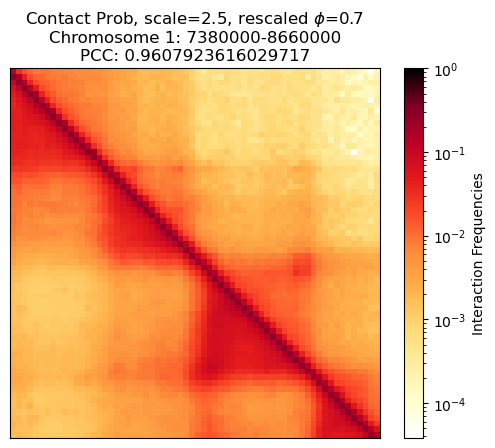

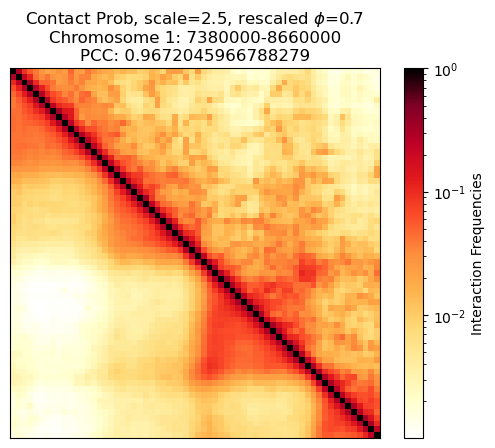

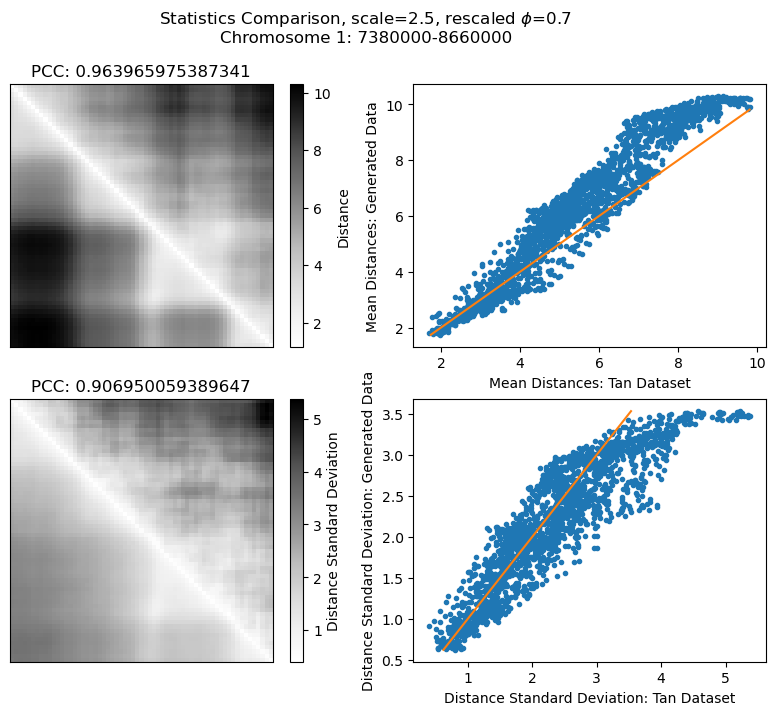

In [29]:
plot_results(
    sample_directory=sample_directory,
    cond_scales=2.5,#3.,#cond_scales,
    rescaled_phis=.7,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms=chroms,
    region_idxs=330,
    r_c=1.,#r_c,
    sigma=.01#sigma
)

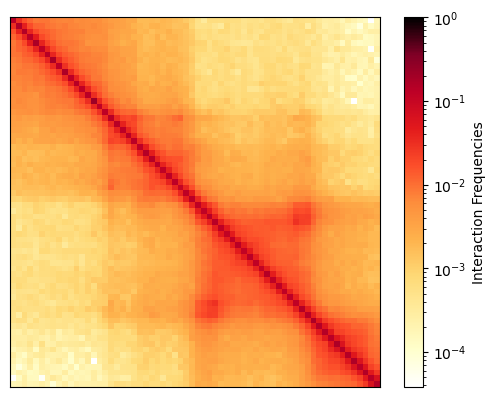

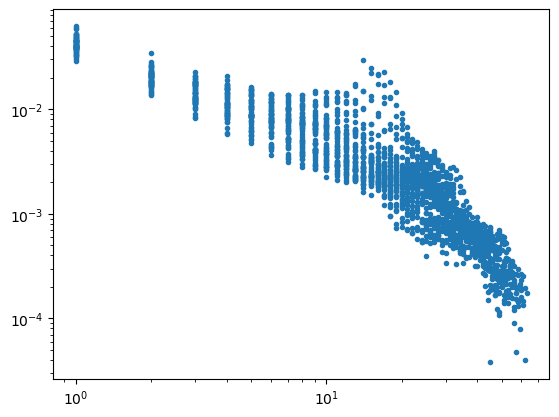

In [37]:
exp_probs = get_exp_map(region_idx=330,chrom='1')
exp_probs.plot()

data = exp_probs.prob_map
n = data.shape[-1]
i,j = torch.triu_indices(n,n,1)
sep = (j-i).numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sep,data[i,j].cpu().numpy(),'.')
ax.set_xscale('log')
ax.set_yscale('log')

Load the generated samples

In [21]:
get_best_r_c_sigma(
    sample_directory=sample_directory,
    cond_scales=None,#5.,#cond_scales,
    rescaled_phis=None,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms='1',#chroms,
    region_idxs=None,#region_idxs,
    r_cs=None,
    sigmas=None,
    use_thresholding=False,
    mean_dists_linear=mean_dists_linear,
    normalize_to_mean=True,#False,
    use_mse=True,
    quartic=False
)

398 samples to process


Outer loop Progress:   0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
get_best_r_c_sigma(
    sample_directory=sample_directory,
    cond_scales=None,#5.,#cond_scales,
    rescaled_phis=None,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms='1',#chroms,
    region_idxs=None,#region_idxs,
    r_cs=None,
    sigmas=None,
    use_thresholding=False,
    mean_dists_linear=mean_dists_linear,
    normalize_to_mean=True,#False,
    use_mse=True,
    quartic=True
)

400 samples to process


Outer loop Progress:   0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
get_best_r_c_sigma(
    sample_directory=sample_directory,
    cond_scales=None,#5.,#cond_scales,
    rescaled_phis=None,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms='1',#chroms,
    region_idxs=None,#region_idxs,
    r_cs=None,
    sigmas=None,
    use_thresholding=False,
    mean_dists_linear=mean_dists_linear,
    normalize_to_mean=False,
    use_mse=False
)

In [ ]:
asdf

2 samples to process


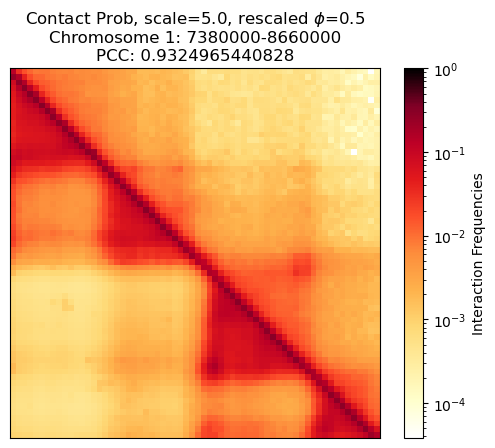

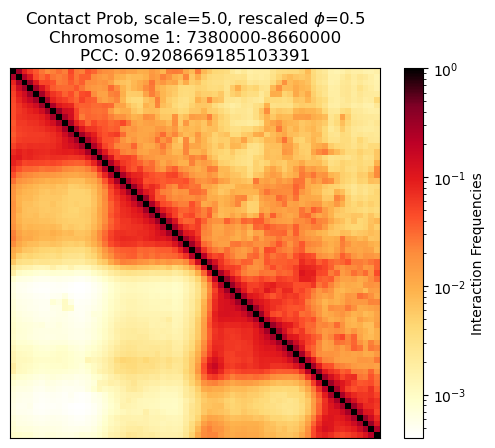

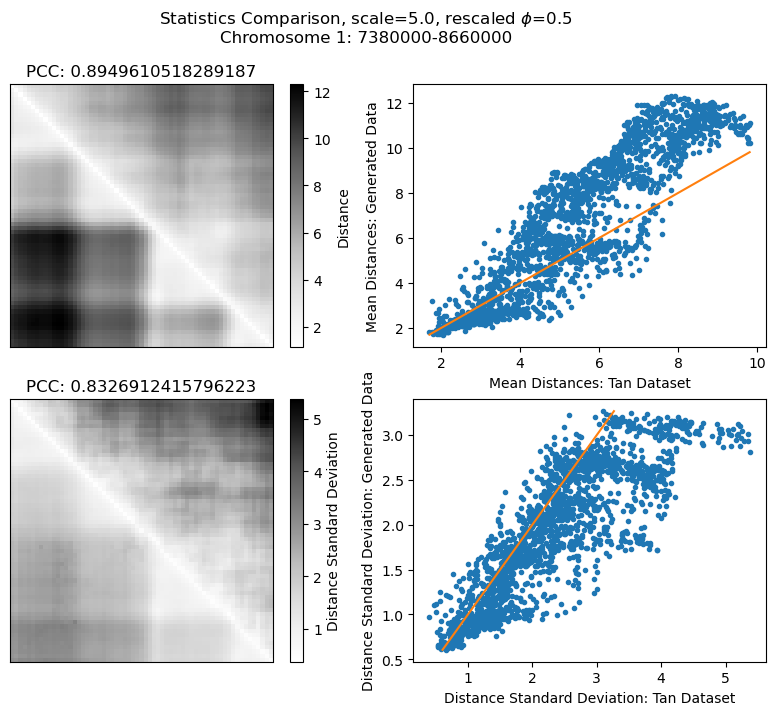

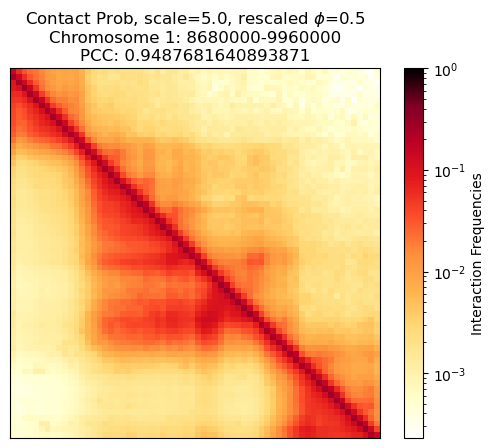

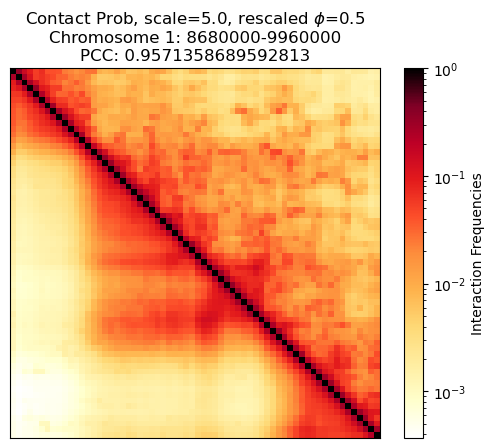

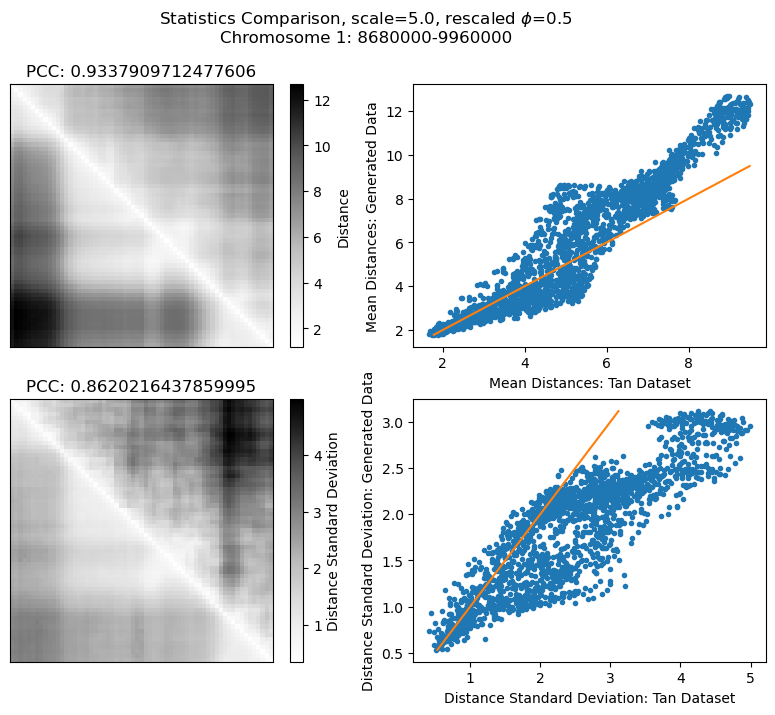

In [29]:
plot_results(
    sample_directory=sample_directory,
    cond_scales=5.,#cond_scales,
    rescaled_phis=.5,#rescaled_phis,
    milestones=51,#milestones,
    chroms=chroms,
    r_c=1.,#r_c,
    sigma=.1#sigma
)

1 samples to process


Progress:   0%|          | 0/1 [00:00<?, ?it/s]

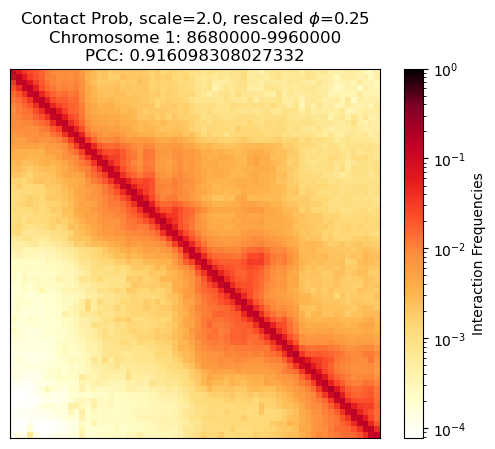

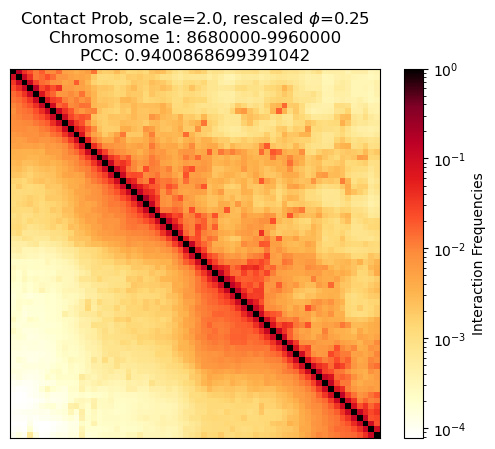

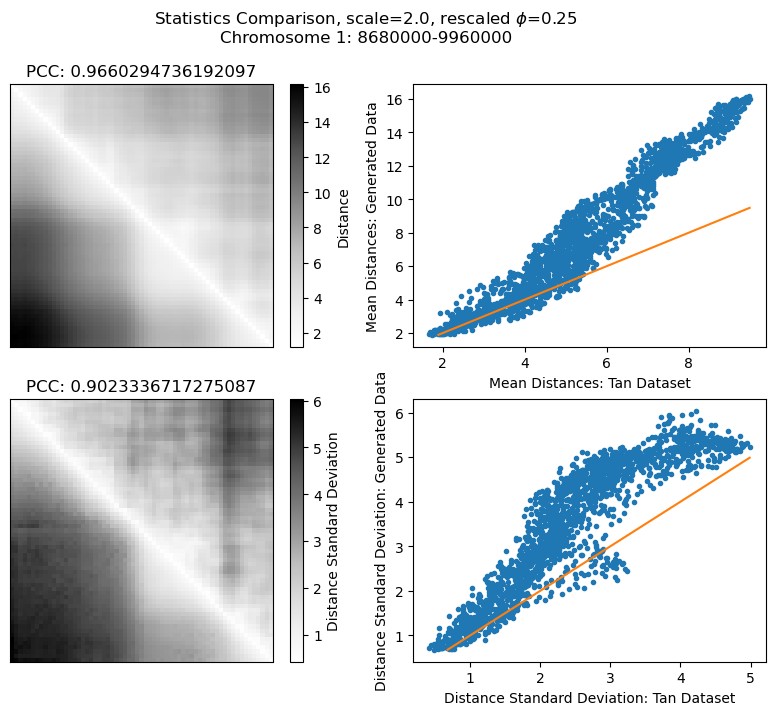

In [41]:
plot_results(
    sample_directory=sample_directory,
    cond_scales=2.,#3.,#cond_scales,
    rescaled_phis=.25,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms=chroms,
    region_idxs=395,
    r_c=.6,##1.,#r_c,
    sigma=.1,#.01#sigma
    quartic=False
)

In [20]:
plot_results(
    sample_directory=sample_directory,
    cond_scales=2.,#3.,#cond_scales,
    rescaled_phis=.75,#.5,#rescaled_phis,
    milestones=120,#milestones,
    chroms=chroms,
    region_idxs=395,
    r_c=1.,#r_c,
    sigma=.01#sigma
)

0 samples to process


Progress: : 0it [00:00, ?it/s]

Guidance .9, rescaling phi .9

In [ ]:
# REMEMBER! Decay at a distance was decreased to **3 from **4 
plot_results(
    sample_directory=sample_directory,
    cond_scales=[3.,4.,5.,6.],#,7.],#cond_scales,
    rescaled_phis=None,#rescaled_phis,
    milestones=None,#milestones,
    chroms=None,#chroms
    r_c=1.1,#r_c,
    sigma=.1,#sigma
    use_thresholding=False #True
)

In [ ]:
plot_results(
    sample_directory=sample_directory,
    cond_scales=[4.],#[3.,4.,5.,6.],#,7.],#cond_scales,
    rescaled_phis=None,#rescaled_phis,
    milestones=None,#milestones,
    chroms=None,#chroms
    r_c=2,#r_c,
    sigma=.1,#sigma
    use_thresholding=True
)

In [ ]:
sample = load_sample(
    region_idx=330,#region_idx,
    cond_scale=4.,#cond_scale,
    rescaled_phi=.7,#rescaled_phi,
    milestone=47,#milestone,
    chrom = '1'#chrom
)

In [ ]:
corrected_hic = sample.contact_probabilities(r_c=1.6,sigma=3.)

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
which_sample = 0 
xline = sample.coords[which_sample,:,0].cpu().numpy()
yline = sample.coords[which_sample,:,1].cpu().numpy()
zline = sample.coords[which_sample,:,2].cpu().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter3D(xline, yline, zline, 'gray')

In [ ]:
which_sample = 5
xline = sample.coords[which_sample,:,0].cpu().numpy()
yline = sample.coords[which_sample,:,1].cpu().numpy()
zline = sample.coords[which_sample,:,2].cpu().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter3D(xline, yline, zline,'Greens',s=100)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')